## Quantitative Analysis

### Kiril Tsarvenkov
email: ktsarvenkov@gmail.com ; mobile: 07 547 914 052

### PART 1 - DATA ANALYSIS

Importing data and setting the index to human readable date from the timestamp columns in the price-usd.csv data.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

df = pd.read_csv('price-usd.csv')

df.index = pd.to_datetime(df.timestamp, unit='s')

del df['timestamp']

# Drop missing values in the dataset ~300 (should not be material for the analysis)
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42360 entries, 2015-08-08 05:00:00 to 2020-06-15 15:00:00
Data columns (total 4 columns):
c    42360 non-null float64
h    42360 non-null float64
l    42360 non-null float64
o    42360 non-null float64
dtypes: float64(4)
memory usage: 1.6 MB


##### PART 1 - DATA ANALYSIS

/home/kiril/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


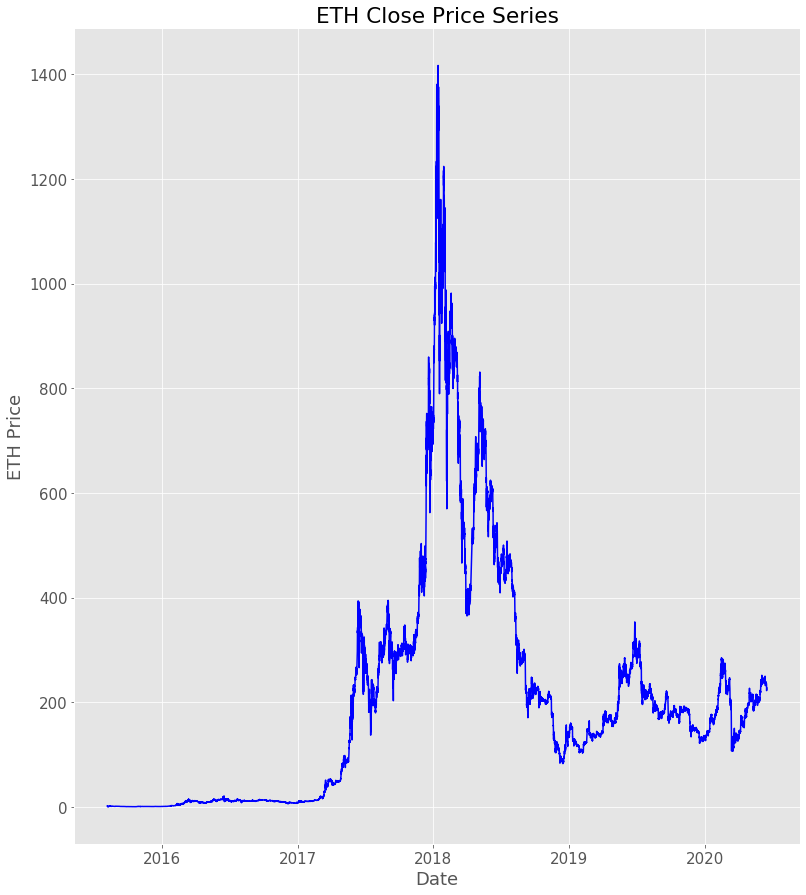

In [2]:
# Task 1
# Visual inspection of the price series 
# Plot the closing price series 
def chart(df1):
    
    plt.style.use('ggplot')
    plt.rcParams.update({'font.size': 15})
    plt.rcParams["figure.figsize"] = (13,15)
    plt.title('ETH Close Price Series')
    plt.ylabel('ETH Price')
    plt.xlabel('Date')
    plt.plot(df1.index, df1.iloc[:,0], color = 'b')
    plt.show()
    
    
chart(df) 


Stationarity is present when a time series distribution exhibits constant mean and variance, and an observation x+1 does not depend on observation x. Consequently, time series which exhibit clear upward/downward trends or seasonality will be non-stationary or formally defined: They will have non-constant mean and variance, and a unit root. Frequently visualisations can show by means of simple eye inspections if the data is trending or not. Price series usually are non-stationary and they have to be adjusted (more on this in the next tasks). Plotting the 'Close' price series of Ethereum ETH shows very erratic price movements with sharp spikes to the upside and sudden drops to the downside which makes it difficult to assess if stationarity is present. As a result, a formal statistical test is required to determine if the series are stationary or not.   

In [3]:
# Formal Statistical test - Augmented Dickey Fuller test 
from statsmodels.tsa.stattools import adfuller

x = df['c'].dropna().values

def adf(data):
    
    res = adfuller(data)
    
    print('ADF Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    print('Critical Values:')
    
    for key,value in res[4].items():
        print('\t%s: %.3f' % (key,value))


adf(x)

ADF Statistic: -1.963743
p-value: 0.302693
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


A Dickey-Fuller test is a formal method for assessing the presence of a unit root in time series. That is, the level of dependence between observations x and x+1. Under this method, the null hypothesis is that the series contain a unit root and the alternative hypothesis is that the series do not contain a unit root. However, the Dickey-Fuller accounts only for a first order dependence (i.e. lag) in the time series which might not capture the relationship appropriately as the stochastic process might be higly persistant with higher order of dependence. Therefore, an Augmented Dickey-Fuller test is more appropriate as it accounts for a higher degree of dependence in the series.

The results show that the Augmented Dickey-Fuller statistic is larger than the critical values at 1%,5% and 10% which means the null hypothesis is not reject and a unit root is present. Additionaly, the same conclusion can be reached by the high p-value of 30.26%.  

In [4]:
# Task 2    
# Create stationary time-series 
def log_returns(df1):
    
    df1['c1'] = df1['c'].shift(-1)
    df1['log_r'] = np.log(df1['c1'] / df['c'])
    
    df1 = df1[['c','c1','log_r']]
    
    return df1


log_ret = log_returns(df)

log_ret.head()

,c,c1,log_r
timestamp,,,
2015-08-08 05:00:00,1.677405,1.655249,-0.013297
2015-08-08 06:00:00,1.655249,1.394904,-0.171126
2015-08-08 07:00:00,1.394904,1.476103,0.056580
2015-08-08 08:00:00,1.476103,1.365256,-0.078064
2015-08-08 09:00:00,1.365256,1.287734,-0.058458


A log return is computed as ln(p1/p). 

Log returns are widely used means to remove the unit root in price series. It also contains convenient statistical properties which allow more flexible approaches to the modelling part. For example, normalization of the data (i.e. measuring all variables in a comparable metric).


ADF Statistic: -29.004054
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


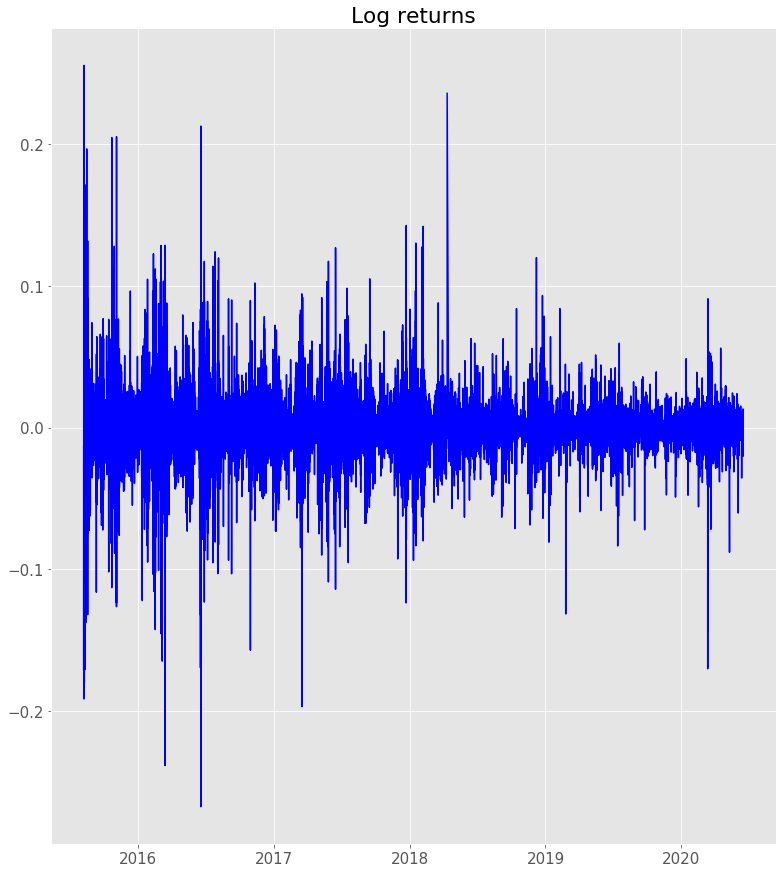

In [5]:
# Task 3 
x = log_ret['log_r'].dropna().values

# Augmented Dickey Fuller test- adf defined above
adf(x)

# Plot the log returns
plt.title('Log returns')
plt.plot(log_ret.index, log_ret.iloc[:,-1], color='b')

Performing an Augmented Dickey-Fuller test again show that this time the null hypothesis of unit is rejected, therefore there is no unit root in the series. Morever, plotting the log returns shows an uncorrelated pattern of returns from one observation to the next one.    

In [6]:
# Task 4
def autocorrs(data,col, granularity, lags):
    '''Resamples the data and plots the auto and partial correlations '''
    
    from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
    
    if granularity != 'H':
        
        data = data.resample(granularity).mean()
        
        
    plt.style.use('ggplot')
    plt.rcParams.update({'font.size': 15})
    plt.rcParams["figure.figsize"] = (10,10)
    
    plot_acf(data[col].dropna(), lags=lags)
    
    plot_pacf(data[col].dropna(), lags=lags)

###  Autocorrelations of the Close price series

Granularity: Hourly


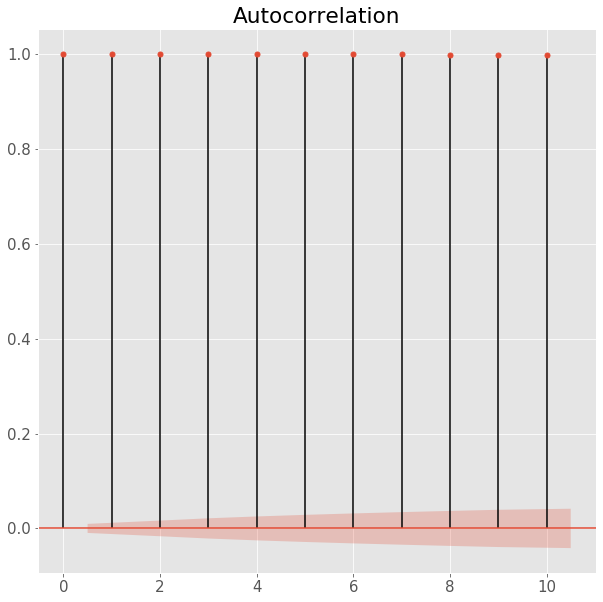

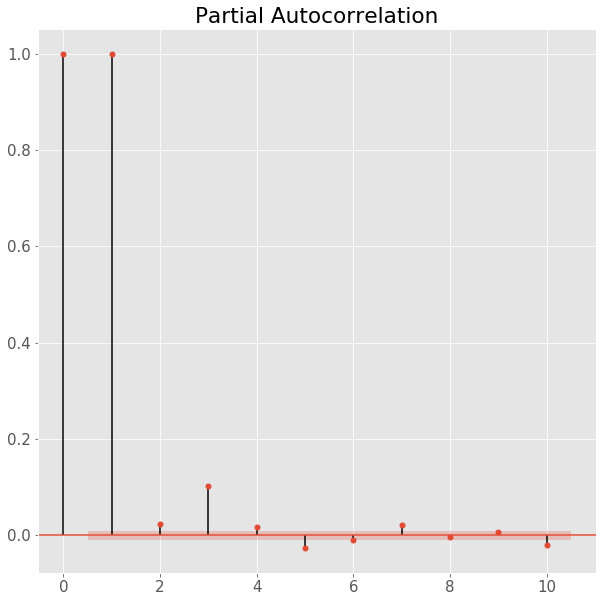

In [7]:
autocorrs(log_ret, 'c', 'H', 10)
print('Granularity: Hourly')

Granularity: Daily


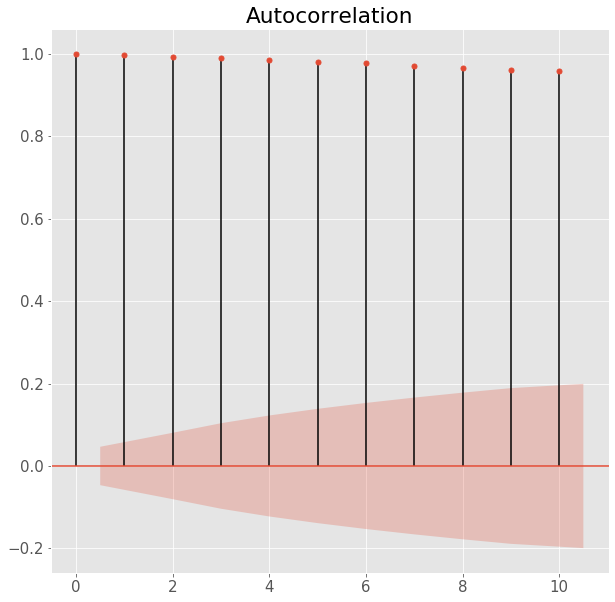

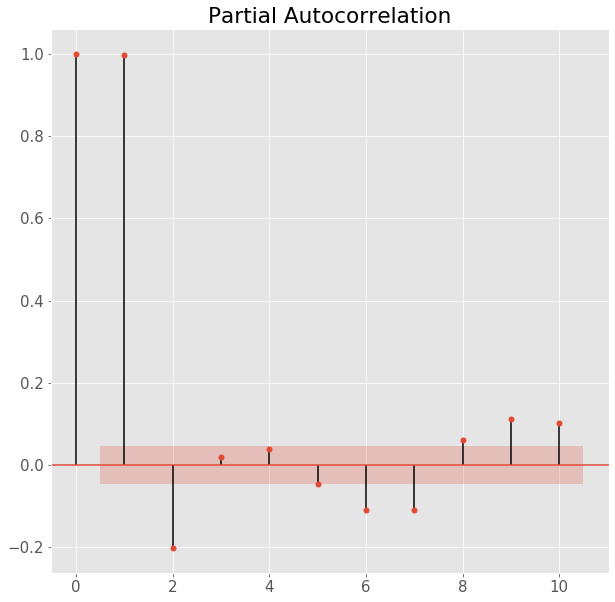

In [8]:
autocorrs(log_ret,'c', 'D',10)
print('Granularity: Daily')

/home/kiril/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Granularity: Weekly


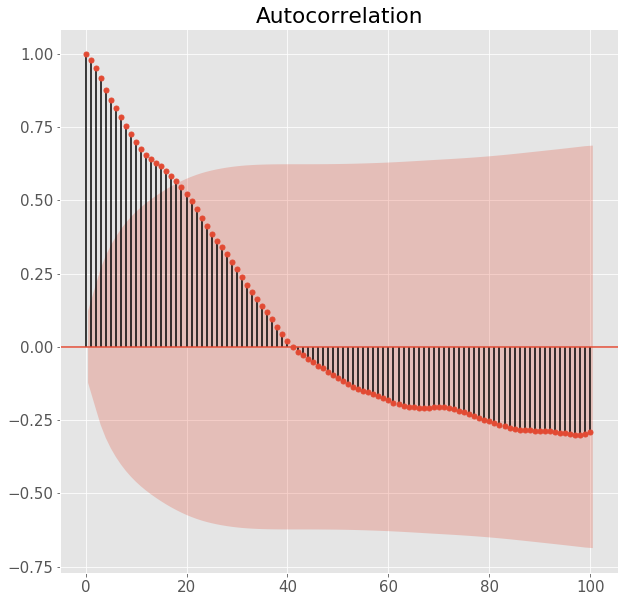

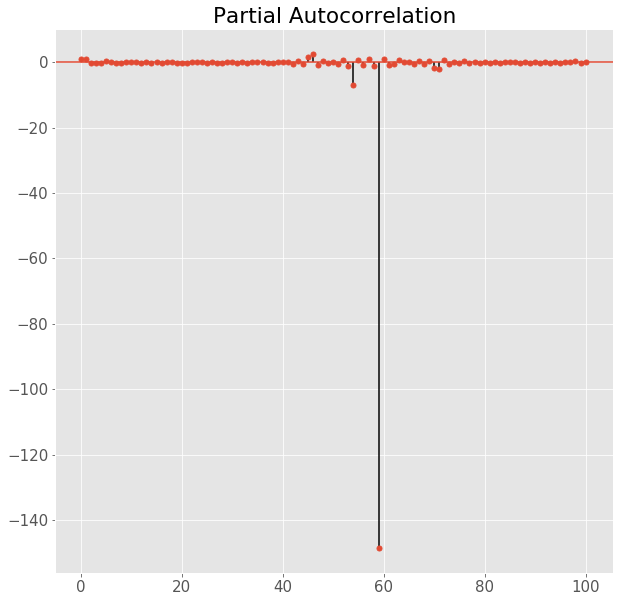

In [9]:
autocorrs(log_ret,'c', 'W',100)
print('Granularity: Weekly')

Granularity: Monthly


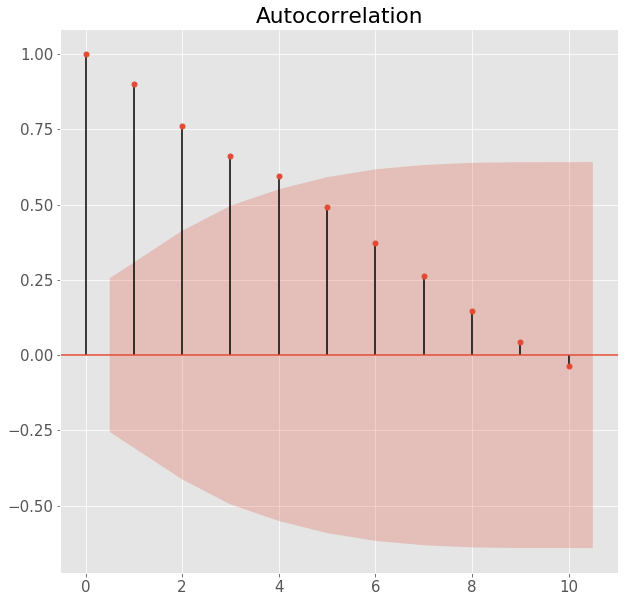

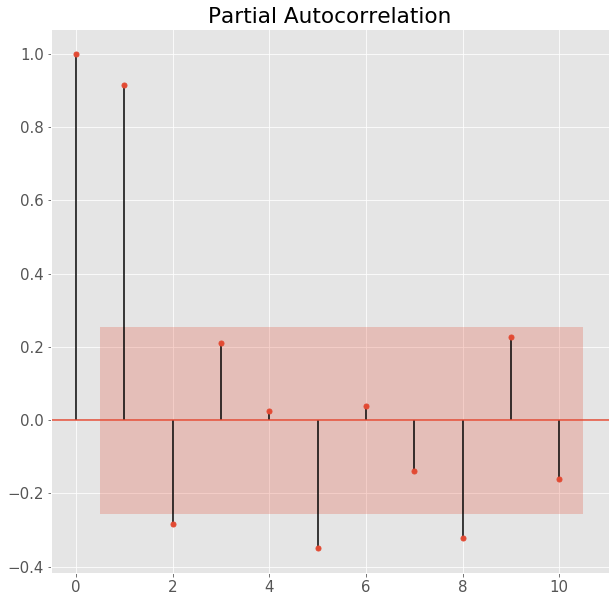

In [10]:
autocorrs(log_ret,'c', 'M',10)
print('Granularity: Monthly')

The autocorrelation plot shows the degree of dependence between individual observations from a time series random variable controlling only for the last lag. That is the degree of association between an observation x with a delayed value x-1 of the same random variable. For the low granularity data such Hourly and Daily, the autocorrelations up to 10 lags are close to 1 which indicates higly persistant unit root times series. As the granularity increases to Weekly and Monthly the correlation turns from positive to negative. However, regardless, of the granularity of the data, the series have to be transformed to create a stationary process.

The partial autocorrelation plot shows the dependence of an observations x with x-n lags of the same variable. This is in contrast with the autocorrelations function which controls for x-1 lag only. The partial autocorrelations show a decreasing degree of autocorrelations as the number of lags increases, however, there are still predictable patterns in the series. 

### Autocorrelation plots for the Log returns.

Granularity: Hourly


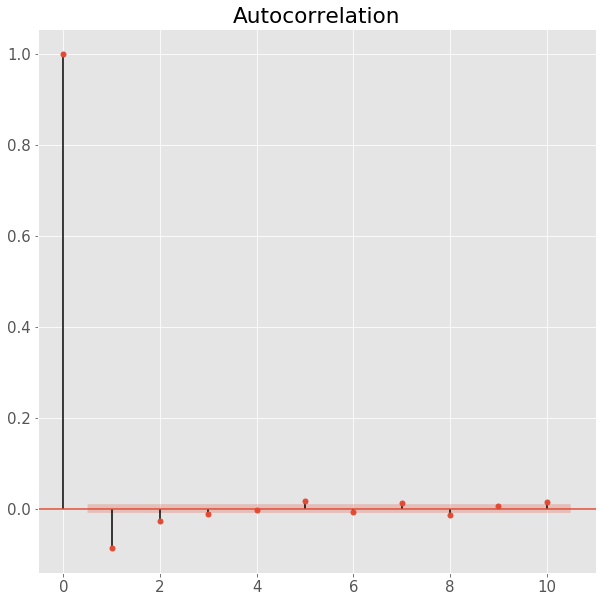

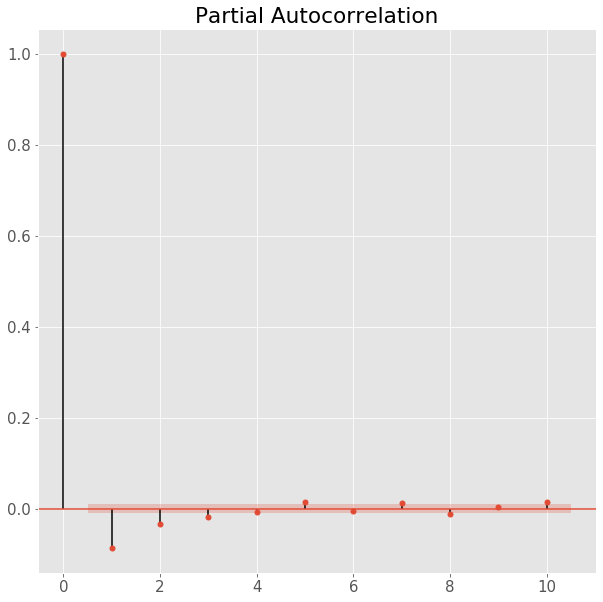

In [11]:
autocorrs(log_ret,'log_r', 'H',10)
print('Granularity: Hourly')

Granularity: Daily


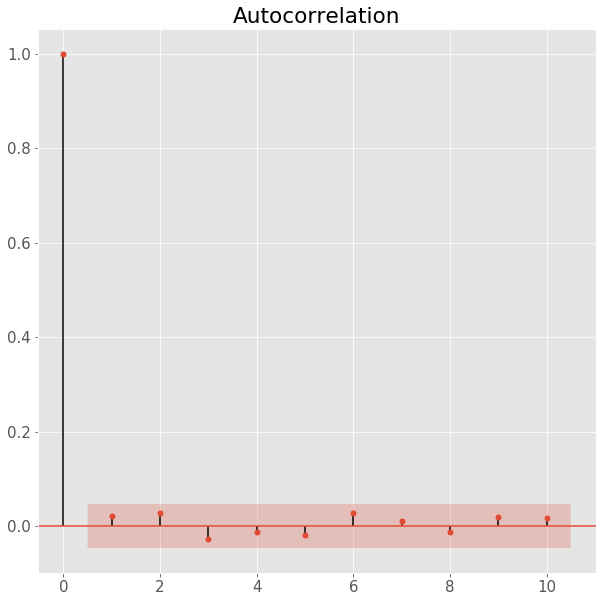

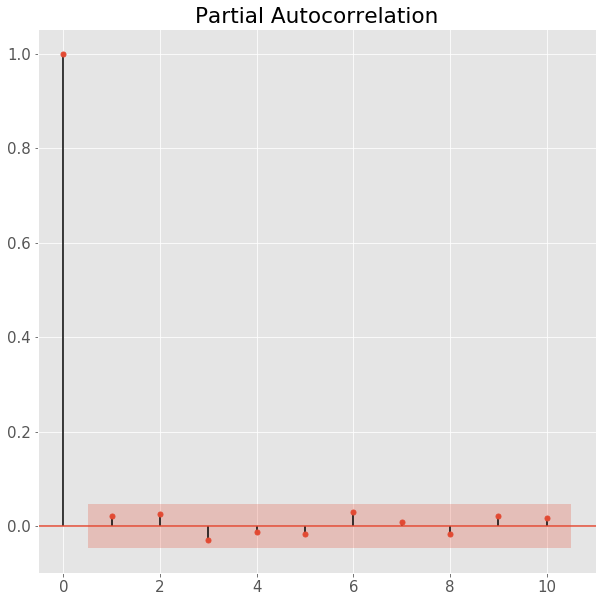

In [12]:
autocorrs(log_ret,'log_r', 'D',10)
print('Granularity: Daily')

Granularity: Weekly


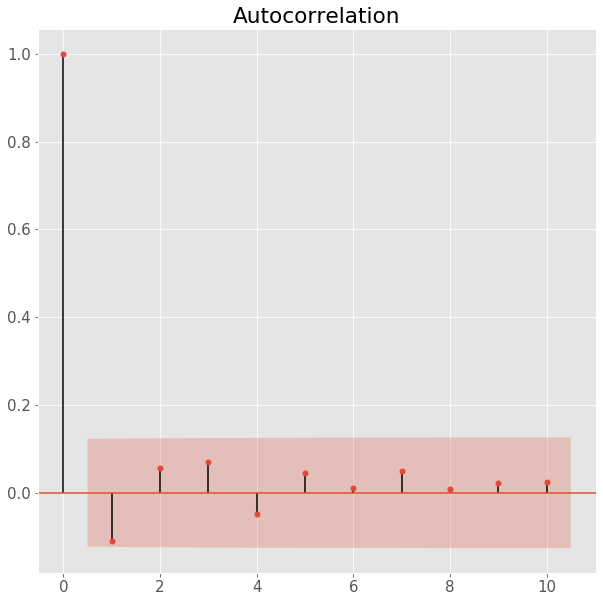

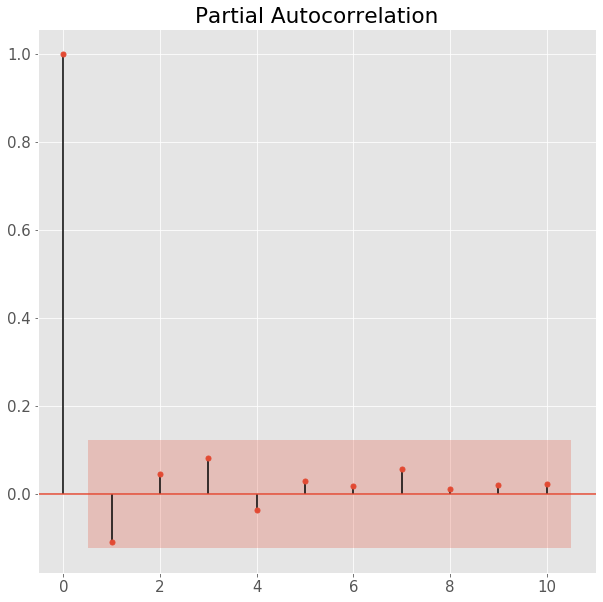

In [13]:
autocorrs(log_ret,'log_r', 'W',10)
print('Granularity: Weekly')

Granularity: Monthly


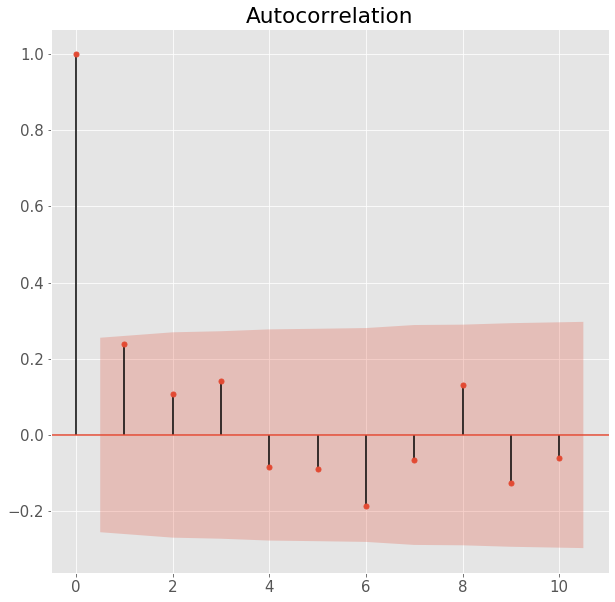

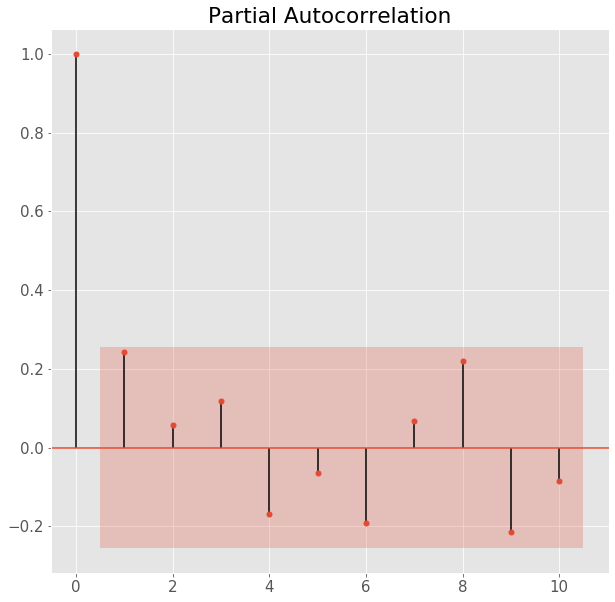

In [14]:
autocorrs(log_ret,'log_r', 'M',10)
print('Granularity: Monthly')

Creating autocorrelation and partial correlation plots for the stationary time series (log returns) reveals that there are no clear patterns, regardless of the granularity of the data. 

P-value is 0.0


Text(0.5, 1.0, 'Distribution of the Log Returns')

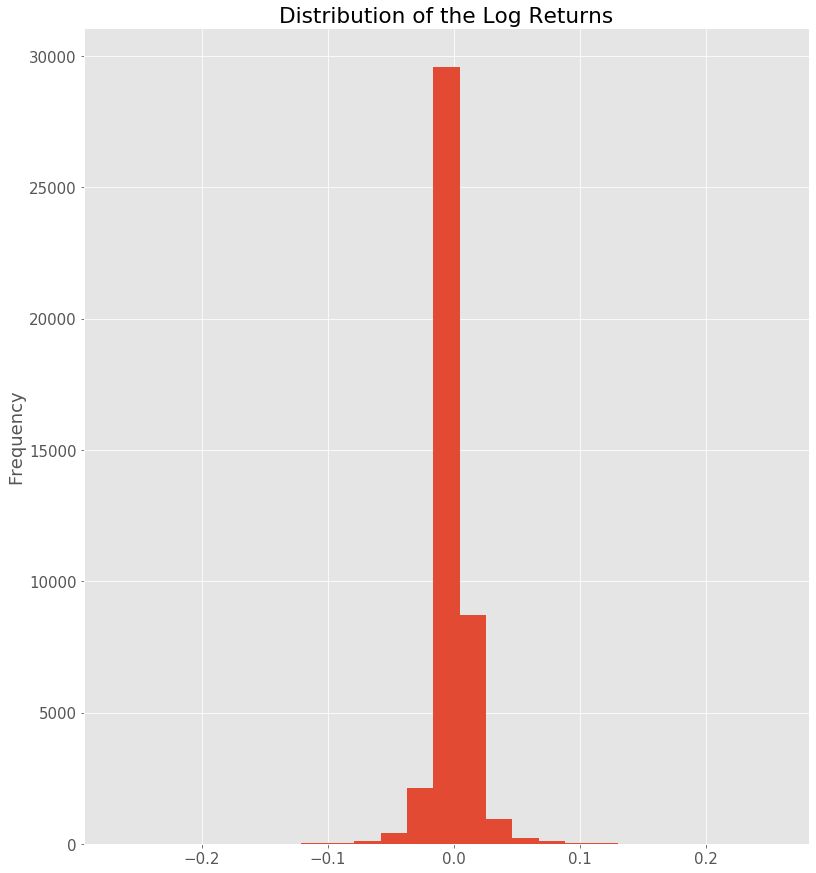

In [15]:
# Task 5 

from scipy import stats
import statsmodels.api as sm

x = log_ret['log_r'].dropna().values
jb = stats.jarque_bera(x)
print('P-value is ' + str(jb[1]))

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (13,15)
log_ret['log_r'].plot(kind='hist', bins=25)
plt.title('Distribution of the Log Returns')

Creating histogram of the data shows a bell shaped distribution which looks very similar to the normal distibution, however the peakedness of the distribution (kurtosis) leads to suspicion, therefore, a formal statistical test is required.
The formal test of choice is the Jarque-Berra test for data normality. The null hypothesis is a joint hypothesis where the third and the fourth moments (skewness and kurtosis) are equal to 0. The alternative hypothesis is that  the they are different from 0. Finally, a P-value of 0 supports the null hypothesis that the data is normally distibuted. 

Task 6 

There are numerous approaches to time series analysis. Two frequent choices are 1. Autoregressive Integrated Moving Average ARIMA processes for prediction and 2. Cointegration. 
Approach one adjust for the presence of unit roots in the series by the use of first differencing. A drawback of this approach is that it does not produce stong reliable results due to failure to adjust for the variance of the series and frequently more sophisticated versions are used such as Generalized Autoregressive Conditional Heteroskedasticity models. The issue with the variance is also present in the log returns derived in this exercise and more sophisticated modelling is required

### PART 2 Creating an Moving Average Strategy

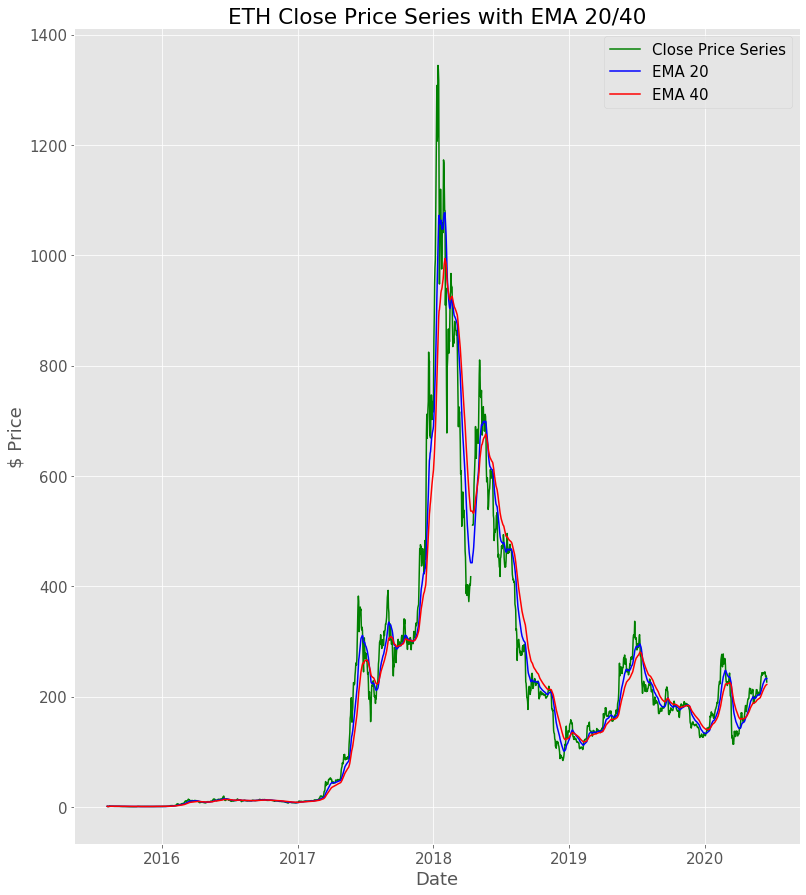

In [16]:
# Task 1

def charts(rets):
    
    data = rets.dropna()
    
# Turn the Hourly data into Daily data to visualise better the data   
    data = data.resample('D').mean()
    
    ema20 = data.ewm(span=20, adjust=False).mean()
    ema20.columns= ['EMA20']
    ema40 = data.ewm(span=40, adjust=True).mean()
    ema40.columns = ['EMA40']
    
    plt.style.use('ggplot')
    plt.rcParams.update({'font.size': 15})
    plt.rcParams["figure.figsize"] = (13,15)
    plt.title('ETH Close Price Series with EMA 20/40')
    plt.xlabel('Date')
    plt.ylabel('$ Price')
    plt.plot(data.index, data, label='Close Price Series', color='g')
    plt.plot(data.index, ema20, label='EMA 20', color='b')
    plt.plot(data.index, ema40, label='EMA 40', color='r')
    plt.legend()
    plt.show()
    
    return (data, ema20, ema40)


show = charts(log_ret[['c']])

In [17]:

# Task 2

data = log_ret['c'].dropna().to_frame()
ema20 = data.ewm(span=20, adjust=False).mean()
ema20.columns= ['EMA20']
ema40 = data.ewm(span=40, adjust=True).mean()
ema40.columns = ['EMA40']
    
data = data.merge(ema20, left_index=True, right_index=True)
data = data.merge(ema40, left_index=True, right_index=True)

data['signal'] = (data['EMA20'] > data['EMA40']) & (data['EMA20'] < data['c']) 

data.head()


,c,EMA20,EMA40,signal
timestamp,,,,
2015-08-08 05:00:00,1.677405,1.677405,1.677405,False
2015-08-08 06:00:00,1.655249,1.675294,1.666050,False
2015-08-08 07:00:00,1.394904,1.648591,1.571112,False
2015-08-08 08:00:00,1.476103,1.632163,1.545549,False
2015-08-08 09:00:00,1.365256,1.606743,1.505797,False


In [18]:
print('signal = True - BUY ; signal = False - Stay in Cash')

signal = True - BUY ; signal = False - Stay in Cash


In [19]:
# Task 3 
# Calculates the total number of buy signals 
buy_signals = data[data['signal'] == True].shape[0]
print('Total number of BUY signals is ' + str(buy_signals))

Total number of BUY signals is 15687


In [20]:

# Task 4
data['lag'] = data['signal'].shift(1)
data['entry_points'] = (data['signal'] == True) & (data['lag'] == False)

# a) Calculates the number of trades 
n_trades = data[ data['entry_points'] == True].shape[0]
print('Total number of trades is ' + str(n_trades))

Total number of trades is 1648


In [21]:

# b) Obtain the cumulative / average return of the strategy 
ret = data[data['signal'] == True]
ret = ret[['c']].diff()
ret.columns = ['r']

cum_ret = ret.sum()[0]

print('The cumulative return of the strategy is ' + str(cum_ret))

avg_ret = round(ret.mean()[0],4)

print('The average return of the strategy is ' + str(avg_ret))

The cumulative return of the strategy is 237.338092406
The average return of the strategy is 0.0151


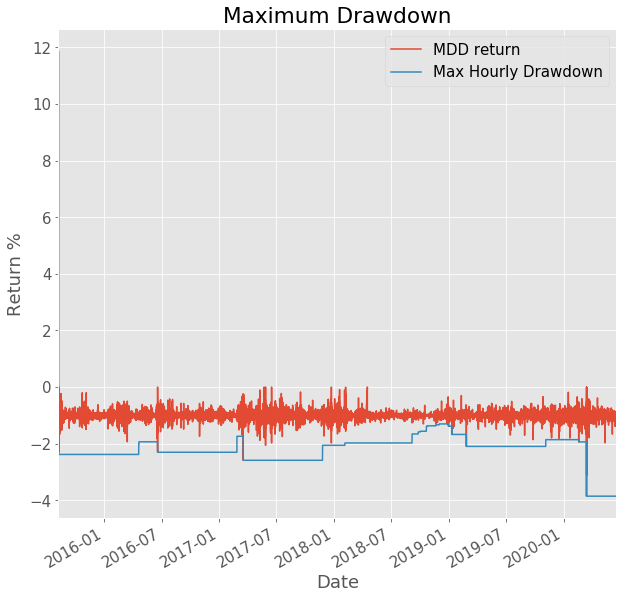

In [22]:
# c) Calculate drawdown

# A drawdown at a given time t is defined as the difference between
# the current equity value
# of the portfolio and the global maximum of the equity curve occurring on or before time t.


data['r'] = np.log(data['c']).diff()
data['equity'] = data['signal'].astype(int) * data['r']

window = 252 * 24

roll_max = data.r.rolling(window, min_periods = 1).max()
h_drawdown = data.r /roll_max - 1


max_hourly_drawdown = h_drawdown.rolling(window, min_periods=1).min()

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10,10)
h_drawdown.plot(label = 'MDD return')
max_hourly_drawdown.plot(label = 'Max Hourly Drawdown')
plt.title('Maximum Drawdown')
plt.legend()
plt.ylabel('Return %')
plt.xlabel('Date')
plt.show()

In [23]:
# Calculate the sharpe ratio = (E(r) - rf)/std*sqrt(252*24) - annualized for hourly data 
# assuming a risk free rate of 0% (current federal funds rate = 0%)

r = data[data['signal'] == True]
r = r['c'].diff()

sharpe = r.mean() / r.std()*np.sqrt(252*24)
sharpe = round(sharpe,4)
print('Sharpe ratio = ' + str(sharpe))

Sharpe ratio = 0.1942


Task 5: 
A technical analysis stategy can be improved by increasing the granularity of the data. For exmaple, instead of hourly data, daily data can be used as there will be less noise on a daily basis compared to per hour basis. This means that weekly and monthly data should provide stronger signals than daily data and they can be considered alternative strategies.

Another possibility to improve the strategy is to increase the number of technical indicators such as Relative Strenght Index, candlestick patterns or other, which in combination with the moving averages can provide a more relialbe signal. 
